In [2]:
import pickle
import torch
import pandas as pd
pd.set_option('display.max_rows', 150)

def read_instance(path):
    with open(path, 'rb') as handle:
        b = pickle.load(handle)
    out_df = pd.DataFrame(b['lb'].cpu()).add_prefix("output_margin_")
    diff = b['x_U'].squeeze()[:,:19].cpu() - b['x_L'].squeeze()[:,:19].cpu()
    diff_df = pd.DataFrame(diff).add_prefix("diff_")
    repetition_df = pd.DataFrame(b['rep'].cpu(), columns=["repetition"])
    pruned_df = pd.DataFrame(1 - (b['lb_plain'] <= 0).all(1).cpu().type(torch.uint8), columns=["pruned_plain"])
    pruned_alpha_df = pd.DataFrame(1 - (b['lb'] <= 0).all(1).cpu().type(torch.uint8), columns=["pruned_alpha"])
    domain_df = pd.concat([out_df, diff_df, repetition_df, pruned_df, pruned_alpha_df], axis=1, join='inner')
    
    return domain_df

In [5]:
# test
pdf = read_instance(path=path.format(4))
plain_prune_ratio = pdf[(pdf['pruned_plain'] == 1)].size / pdf.size
alpha_gain = pdf[(pdf['pruned_alpha'] == 1) & (pdf['pruned_plain'] == 0)].size / pdf.size
alpha_loss = pdf[(pdf['pruned_alpha'] == 0) & (pdf['pruned_plain'] == 1)].size / pdf.size
print(plain_prune_ratio, alpha_gain, alpha_loss)

0.64546875 0.295925 0.0027625


## lower:0.4 upper:0.6

In [ ]:
path = "/home/mzi/sys-rl-verif/alpha-beta-CROWN/complete_verifier/input_split/pickled/alpha_partition20_iteration10_in19_lower04_upper06_eps001_out15_0_14/{}.pickle"

### prune vs repetition vs iteration

In [3]:
pdf_all = read_instance(path=path.format(0))[['pruned_plain', 'pruned_alpha', 'repetition']]
pdf_all['iteration'] = 0

for i in range(1, 1922):
    pdf = read_instance(path=path.format(i))[['pruned_plain', 'pruned_alpha', 'repetition']]
    pdf['iteration'] = i
    pdf_all = pd.concat([pdf, pdf_all])


#### distr of repetition across iterations

In [4]:
pdf_sampled = pdf_all[pdf_all['iteration'] % 100 == 0]
pdf_count = pdf_sampled.groupby('iteration').count()
pdf_count = pdf_count[['repetition']].rename(columns={'repetition': 'count'})
pdf_iter = pdf_sampled[['iteration', 'repetition']].groupby(['iteration']).agg(['mean', 'min', 'max'])
pdf_prune = pdf_sampled[['pruned_plain', 'pruned_alpha', 'iteration']].groupby(['iteration']).mean()
pd.concat([pdf_count, pdf_iter, pdf_prune], axis=1, join='inner')


,count,"(repetition, mean)","(repetition, min)","(repetition, max)",pruned_plain,pruned_alpha
iteration,,,,,,
0,400,2.000000,2.0,2.0,0.000000,0.000000
100,160000,6.305500,6.0,7.0,0.707838,0.985425
200,160000,6.395250,6.0,7.0,0.820087,0.983625
300,160000,7.014750,7.0,8.0,0.652775,0.998150
400,160000,7.050000,7.0,8.0,0.745381,0.999056
500,160000,7.414375,7.0,8.0,0.593688,0.989162
600,160000,7.024125,7.0,8.0,0.671837,0.999281
700,160000,7.130875,7.0,8.0,0.649306,0.994556
800,160000,7.046875,7.0,8.0,0.829956,0.999181


#### distr of iterations across repetitions

In [5]:
pdf_count = pdf_all.groupby('repetition').count()
pdf_count = pdf_count[['iteration']].rename(columns={'iteration': 'count'})
pdf_rep = pdf_all[['iteration', 'repetition']].groupby(['repetition']).agg(['mean', 'min', 'max'])
pd.concat([pdf_count, pdf_rep], axis=1, join='inner')


,count,"(iteration, mean)","(iteration, min)","(iteration, max)"
repetition,,,,
2.0,400,0.000000,0,0
3.0,8000,1.000000,1,1
4.0,160000,2.000000,2,2
5.0,3200000,552.059062,3,1899
6.0,48962000,621.267441,4,1920
7.0,221666900,994.195231,5,1921
8.0,32923200,1283.436267,53,1918
9.0,1200,1639.016667,1350,1698


#### distr of pruning across repetition

In [6]:
pdf_count = pdf_all.groupby('repetition').count()
pdf_count = pdf_count[['iteration']].rename(columns={'iteration': 'count'})
pdf_prune = pdf_all[['pruned_plain', 'pruned_alpha', 'repetition']].groupby(['repetition']).agg(['sum', 'mean'])
pd.concat([pdf_count, pdf_prune], axis=1, join='inner')

,count,"(pruned_plain, sum)","(pruned_plain, mean)","(pruned_alpha, sum)","(pruned_alpha, mean)"
repetition,,,,,
2.0,400,0,0.000000,0,0.000000
3.0,8000,0,0.000000,0,0.000000
4.0,160000,121,0.000756,0,0.000000
5.0,3200000,793334,0.247917,751900,0.234969
6.0,48962000,26651298,0.544326,37878655,0.773634
7.0,221666900,156369919,0.705427,220020740,0.992574
8.0,32923200,22418598,0.680936,32923140,0.999998
9.0,1200,1076,0.896667,1200,1.000000


<Axes: xlabel='repetition'>

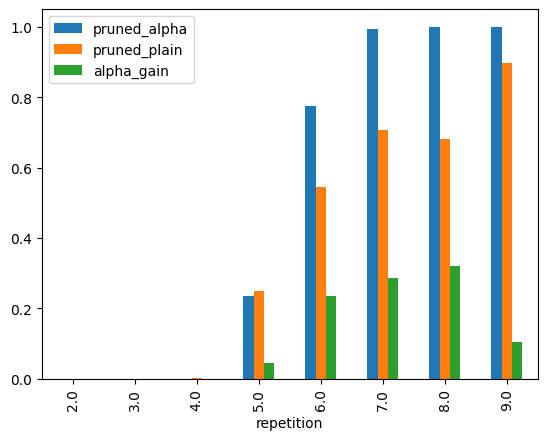

In [10]:
pdf_all['alpha_gain'] = ((pdf_all['pruned_alpha'] == 1) & (pdf_all['pruned_plain'] == 0))
pdf_all["alpha_gain"] = pdf_all["alpha_gain"].astype(int)
pdf_all[["repetition", "pruned_alpha", "pruned_plain", "alpha_gain"]].groupby("repetition").mean().plot.bar()

#### prune vs repetition vs alpha-gain across iterations

In [3]:
path = "/home/mzi/sys-rl-verif/alpha-beta-CROWN/complete_verifier/input_split/pickled/alpha_partition20_iteration10_in19_lower04_upper06_eps001_out15_0_14/{}.pickle"

plain_prune_ratio_list = []
alpha_prune_ratio_list = []
alpha_gain_list = []
alpha_loss_list = []
repetition_avg_list = []

for i in range(1922):
    pdf = read_instance(path=path.format(i))[['pruned_plain', 'pruned_alpha', 'repetition']]
    
    plain_prune_ratio = pdf[(pdf['pruned_plain'] == 1)].size / pdf.size
    alpha_prune_ratio = pdf[(pdf['pruned_alpha'] == 1)].size / pdf.size
    alpha_gain = pdf[(pdf['pruned_alpha'] == 1) & (pdf['pruned_plain'] == 0)].size / pdf.size
    alpha_loss = pdf[(pdf['pruned_alpha'] == 0) & (pdf['pruned_plain'] == 1)].size / pdf.size
    
    plain_prune_ratio_list.append(plain_prune_ratio)
    alpha_prune_ratio_list.append(alpha_prune_ratio)
    alpha_gain_list.append(alpha_gain)
    alpha_loss_list.append(alpha_loss)
    repetition_avg_list.append(pdf.repetition.mean())


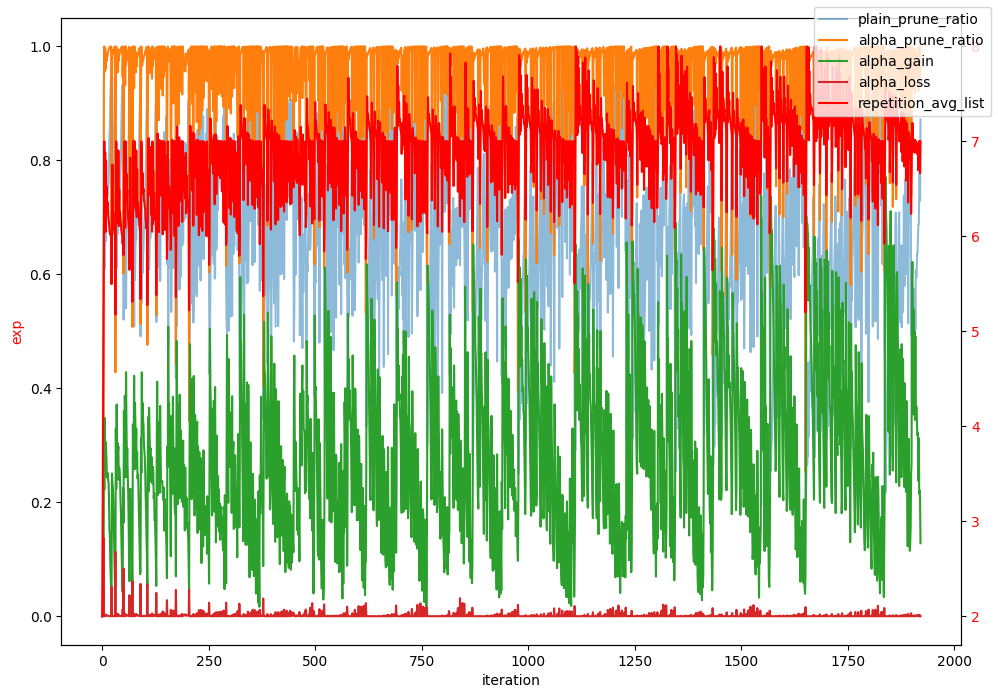

In [4]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlabel('iteration')
ax1.set_ylabel('exp', color="red")
ax1.plot(plain_prune_ratio_list, label="plain_prune_ratio", alpha=0.5)
ax1.plot(alpha_prune_ratio_list, label="alpha_prune_ratio")
ax1.plot(alpha_gain_list, label="alpha_gain")
ax1.plot(alpha_loss_list, label="alpha_loss")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(repetition_avg_list, color="red", label="repetition_avg_list")
ax2.tick_params(axis='y', labelcolor="red")

fig.tight_layout()
fig.legend()
plt.show()

### prune vs margin

In [28]:
pdf_all = read_instance(path=path.format(0))
pdf_sampled['iteration'] = 0

for i in range(1, 1922, 200):
    pdf = read_instance(path=path.format(i))
    pdf['iteration'] = i
    pdf_sampled = pd.concat([pdf, pdf_all])


/tmp/ipykernel_735758/4259828369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_sampled['iteration'] = 0


#### find narrowest marigin idx

In [30]:
def find_top5(row):
    subset_columns = [f'output_margin_{i}' for i in range(28)]
    names = row[subset_columns].sort_values(ascending=False).head(5).index
    return pd.Series([int(name.split("_")[-1]) for name in names], index=['top_1', 'top_2', 'top_3', 'top_4', 'top_5']) # tuple()

pdf_sampled[['top_1', 'top_2', 'top_3', 'top_4', 'top_5']] = pdf_sampled.apply(find_top5, axis=1)


In [31]:
pdf_sampled[['top_1', 'top_2', 'top_3', 'top_4', 'top_5']].describe()

,top_1,top_2,top_3,top_4,top_5
count,160400.000000,160400.000000,160400.000000,160400.000000,160400.000000
mean,10.999489,9.000511,16.045081,14.800374,6.067238
std,0.031972,0.031972,8.875268,7.956549,7.756197
min,9.000000,9.000000,8.000000,1.000000,1.000000
25%,11.000000,9.000000,8.000000,8.000000,1.000000
50%,11.000000,9.000000,8.000000,13.000000,1.000000
75%,11.000000,9.000000,26.000000,26.000000,13.000000
max,11.000000,11.000000,26.000000,26.000000,26.000000


#### find positive margin idx

In [45]:
def locate_pos(row):
    for i in range(28):
        if row[f'output_margin_{i}'] > 0:
            return i
    
    return None

pdf_sampled['pos_prop'] = pdf_sampled.apply(locate_pos, axis=1)
pdf_pruned = pdf_sampled.dropna()

print(pdf_sampled.shape[0], float(pdf_pruned.shape[0]) / float(pdf_sampled.shape[0]), pdf_pruned.shape[0])
pdf_pruned.groupby('pos_prop').count()[['output_margin_0']].rename(columns={'output_margin_0': 'count'})


160400 0.992356608478803 159174


,count
pos_prop,
9.0,97324
11.0,61850


## lower:0.4 upper:0.8

In [46]:
path = "/home/mzi/sys-rl-verif/alpha-beta-CROWN/complete_verifier/input_split/pickled/alpha_partition20_iteration10_in19_lower04_upper08_eps001_out15_0_14/{}.pickle"

### prune vs repetition vs iteration

In [51]:
pdf_all = read_instance(path=path.format(0))[['pruned_plain', 'pruned_alpha', 'repetition']]
pdf_all['iteration'] = 0

for i in range(1, 11171, 100):
    pdf = read_instance(path=path.format(i))[['pruned_plain', 'pruned_alpha', 'repetition']]
    pdf['iteration'] = i
    pdf_all = pd.concat([pdf, pdf_all])

pdf_all.size

36406080

#### distr of repetition across iterations

In [53]:
pdf_sampled = pdf_all[pdf_all['iteration'] % 1 == 0]
pdf_count = pdf_sampled.groupby('iteration').count()
pdf_count = pdf_count[['repetition']].rename(columns={'repetition': 'count'})
pdf_iter = pdf_sampled[['iteration', 'repetition']].groupby(['iteration']).agg(['mean', 'min', 'max'])
pdf_prune = pdf_sampled[['pruned_plain', 'pruned_alpha', 'iteration']].groupby(['iteration']).mean()
pd.concat([pdf_count, pdf_iter, pdf_prune], axis=1, join='inner')


,count,"(repetition, mean)","(repetition, min)","(repetition, max)",pruned_plain,pruned_alpha
iteration,,,,,,
0,400,2.000000,2.0,2.0,0.000000,0.000000
1,8000,3.000000,3.0,3.0,0.000000,0.000000
101,81920,16.015869,16.0,17.0,0.499854,0.999121
201,81920,15.375488,15.0,17.0,0.482349,0.973950
301,81920,15.535156,15.0,17.0,0.660864,0.963086
401,81920,16.209473,15.0,17.0,0.872021,0.998914
501,81920,17.000000,17.0,17.0,0.980090,1.000000
601,81920,16.697754,16.0,17.0,0.785632,0.971643
701,81920,17.000000,17.0,17.0,0.999011,1.000000


#### distr of iterations across repetitions

In [54]:
pdf_count = pdf_all.groupby('repetition').count()
pdf_count = pdf_count[['iteration']].rename(columns={'iteration': 'count'})
pdf_rep = pdf_all[['iteration', 'repetition']].groupby(['repetition']).agg(['mean', 'min', 'max'])
pd.concat([pdf_count, pdf_rep], axis=1, join='inner')


,count,"(iteration, mean)","(iteration, min)","(iteration, max)"
repetition,,,,
2.0,400,0.000000,0,0
3.0,8000,1.000000,1,1
14.0,62880,4996.642494,1201,6701
15.0,1894320,5413.001140,201,11001
16.0,2706240,5546.322662,101,11101
17.0,4426740,5722.427958,101,11101
18.0,2940,7156.102041,2601,9601


#### distr of pruning across repetition

In [55]:
pdf_count = pdf_all.groupby('repetition').count()
pdf_count = pdf_count[['iteration']].rename(columns={'iteration': 'count'})
pdf_prune = pdf_all[['pruned_plain', 'pruned_alpha', 'repetition']].groupby(['repetition']).agg(['sum', 'mean'])
pd.concat([pdf_count, pdf_prune], axis=1, join='inner')

,count,"(pruned_plain, sum)","(pruned_plain, mean)","(pruned_alpha, sum)","(pruned_alpha, mean)"
repetition,,,,,
2.0,400,0,0.000000,0,0.000000
3.0,8000,0,0.000000,0,0.000000
14.0,62880,19200,0.305344,21344,0.339440
15.0,1894320,1283303,0.677448,1747531,0.922511
16.0,2706240,1617570,0.597719,2416930,0.893095
17.0,4426740,3416793,0.771853,4426426,0.999929
18.0,2940,2940,1.000000,2940,1.000000


<Axes: xlabel='repetition'>

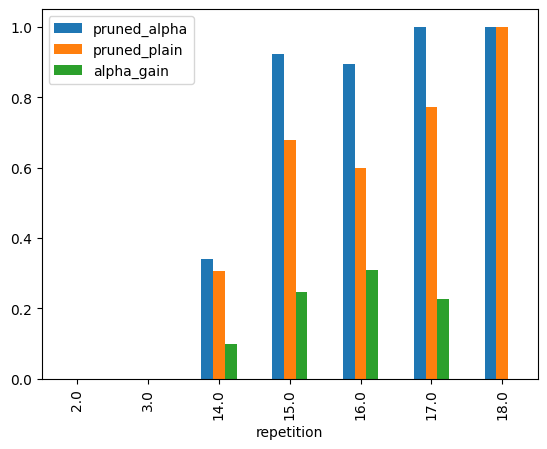

In [56]:
pdf_all['alpha_gain'] = ((pdf_all['pruned_alpha'] == 1) & (pdf_all['pruned_plain'] == 0))
pdf_all["alpha_gain"] = pdf_all["alpha_gain"].astype(int)
pdf_all[["repetition", "pruned_alpha", "pruned_plain", "alpha_gain"]].groupby("repetition").mean().plot.bar()

#### prune vs repetition vs alpha-gain across iterations

In [58]:
plain_prune_ratio_list = []
alpha_prune_ratio_list = []
alpha_gain_list = []
alpha_loss_list = []
repetition_avg_list = []

for i in range(0, 11171, 50):
    pdf = read_instance(path=path.format(i))[['pruned_plain', 'pruned_alpha', 'repetition']]
    
    plain_prune_ratio = pdf[(pdf['pruned_plain'] == 1)].size / pdf.size
    alpha_prune_ratio = pdf[(pdf['pruned_alpha'] == 1)].size / pdf.size
    alpha_gain = pdf[(pdf['pruned_alpha'] == 1) & (pdf['pruned_plain'] == 0)].size / pdf.size
    alpha_loss = pdf[(pdf['pruned_alpha'] == 0) & (pdf['pruned_plain'] == 1)].size / pdf.size
    
    plain_prune_ratio_list.append(plain_prune_ratio)
    alpha_prune_ratio_list.append(alpha_prune_ratio)
    alpha_gain_list.append(alpha_gain)
    alpha_loss_list.append(alpha_loss)
    repetition_avg_list.append(pdf.repetition.mean())


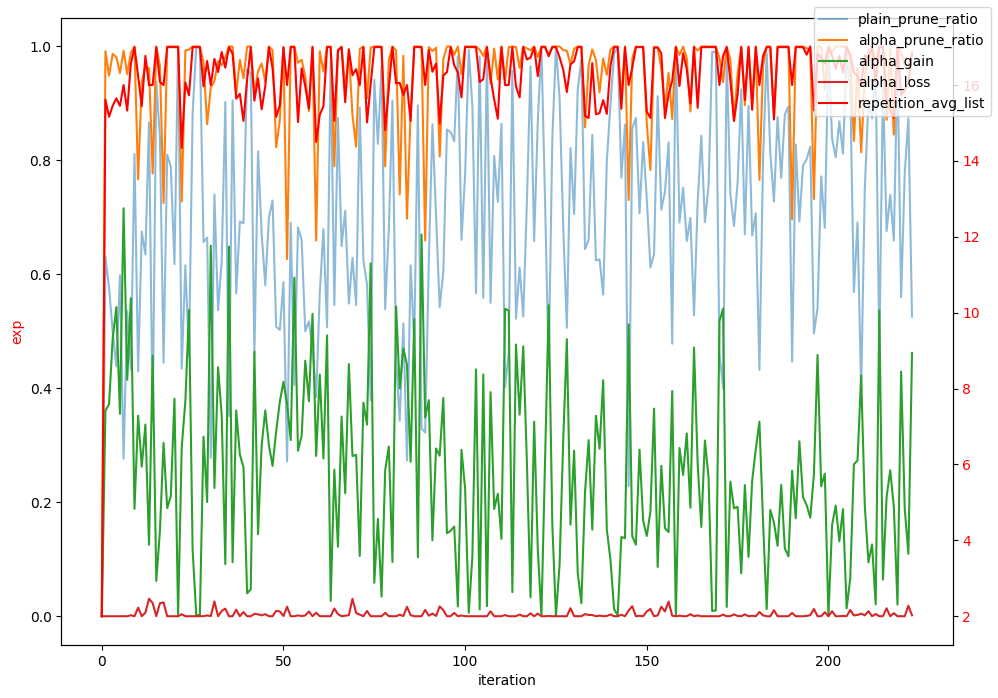

In [59]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlabel('iteration')
ax1.set_ylabel('exp', color="red")
ax1.plot(plain_prune_ratio_list, label="plain_prune_ratio", alpha=0.5)
ax1.plot(alpha_prune_ratio_list, label="alpha_prune_ratio")
ax1.plot(alpha_gain_list, label="alpha_gain")
ax1.plot(alpha_loss_list, label="alpha_loss")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(repetition_avg_list, color="red", label="repetition_avg_list")
ax2.tick_params(axis='y', labelcolor="red")

fig.tight_layout()
fig.legend()
plt.show()

### prune vs margin

In [60]:
pdf_all = read_instance(path=path.format(0))
pdf_sampled['iteration'] = 0

for i in range(1, 11171, 200):
    pdf = read_instance(path=path.format(i))
    pdf['iteration'] = i
    pdf_sampled = pd.concat([pdf, pdf_all])


#### find narrowest marigin idx

In [61]:
def find_top5(row):
    subset_columns = [f'output_margin_{i}' for i in range(28)]
    names = row[subset_columns].sort_values(ascending=False).head(5).index
    return pd.Series([int(name.split("_")[-1]) for name in names], index=['top_1', 'top_2', 'top_3', 'top_4', 'top_5']) # tuple()

pdf_sampled[['top_1', 'top_2', 'top_3', 'top_4', 'top_5']] = pdf_sampled.apply(find_top5, axis=1)


In [62]:
pdf_sampled[['top_1', 'top_2', 'top_3', 'top_4', 'top_5']].describe()

,top_1,top_2,top_3,top_4,top_5
count,82320.000000,82320.000000,82320.000000,82320.000000,82320.000000
mean,10.543647,9.738010,13.487488,11.402648,8.989735
std,2.320580,1.482145,8.203933,10.191879,10.040779
min,9.000000,1.000000,8.000000,1.000000,1.000000
25%,9.000000,9.000000,8.000000,1.000000,1.000000
50%,11.000000,9.000000,8.000000,8.000000,1.000000
75%,11.000000,11.000000,26.000000,26.000000,13.000000
max,26.000000,26.000000,26.000000,26.000000,26.000000


#### find positive margin idx

In [63]:
def locate_pos(row):
    for i in range(28):
        if row[f'output_margin_{i}'] > 0:
            return i
    
    return None

pdf_sampled['pos_prop'] = pdf_sampled.apply(locate_pos, axis=1)
pdf_pruned = pdf_sampled.dropna()

print(pdf_sampled.shape[0], float(pdf_pruned.shape[0]) / float(pdf_sampled.shape[0]), pdf_pruned.shape[0])
pdf_pruned.groupby('pos_prop').count()[['output_margin_0']].rename(columns={'output_margin_0': 'count'})


82320 0.9646137026239067 79407


,count
pos_prop,
0.0,75
1.0,1191
8.0,2135
9.0,70171
11.0,5324
26.0,511
